In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import numpy as np
import sklearn.metrics
from sklearn.model_selection import train_test_split

import seaborn as sns

In [3]:
df = pd.read_excel('project_output.xls')

In [4]:
df.fillna(0,inplace=True)

In [5]:
df['GatewayLoad'] = df.apply(lambda x: x['GatewayCount']/x['CourseCount'],axis=1)

## Data Exploration

Before removing the term code and major from the data, I want to see if there are any valuable insights.

In [12]:
df_ret = df[df['FS_RET']==1]
df_drop = df[df['FS_RET']==0]

In [13]:
print('Retained:',len(df_ret))
print('Dropped:',len(df_drop))

Retained: 2007
Dropped: 572


In [14]:
df.groupby('FS_RET')['GatewayCount'].mean()

FS_RET
0    3.552448
1    3.704534
Name: GatewayCount, dtype: float64

In [15]:
df_ret.groupby('TERM')['DFIW'].mean()

TERM
201608    0.189090
201708    0.205502
Name: DFIW, dtype: float64

In [16]:
df_drop.groupby('TERM')['DFIW'].mean()

TERM
201608    0.665795
201708    0.693338
Name: DFIW, dtype: float64

In [17]:
df_ret.groupby('TERM')['DFIW_Gateway'].mean()

TERM
201608    0.176456
201708    0.187841
Name: DFIW_Gateway, dtype: float64

In [18]:
df_drop.groupby('TERM')['DFIW_Gateway'].mean()

TERM
201608    0.606170
201708    0.648738
Name: DFIW_Gateway, dtype: float64

In [6]:
df_ret.groupby('TERM')['GPA'].mean()

TERM
201608    2.419590
201708    2.374136
Name: GPA, dtype: float64

In [15]:
df_drop.groupby('TERM')['GPA'].mean()

TERM
201608    1.167493
201708    1.101935
Name: GPA, dtype: float64

In [7]:
df.groupby('FS_RET')['GPA'].mean()

FS_RET
0    1.142622
1    2.760473
Name: GPA, dtype: float64

In [19]:
major_DFIW = df.groupby('Major')['DFIW'].mean()

In [21]:
major_DFIW.mean()

0.29379639408926506

In [8]:
major_sort = major_DFIW.sort_values()

Text(0.5, 1.0, 'DFW Rate by Major')

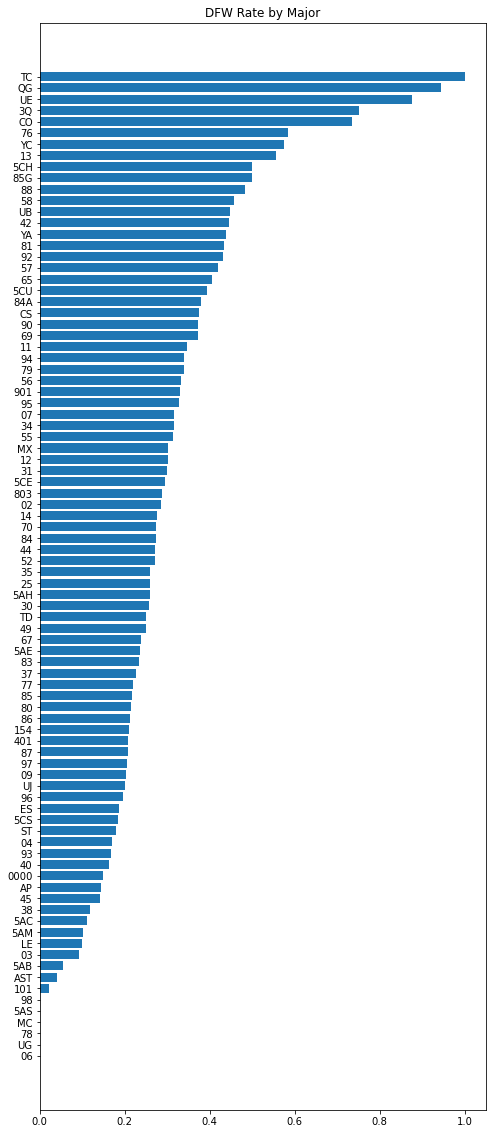

In [9]:
plt.figure(figsize=(8,20))
plt.barh(width=major_sort.values,y=major_sort.index)
plt.title('DFW Rate by Major')

In general things are trending downards, but that is something to explore later with more data.

In [5]:
df.drop(columns=['TERM','ID','Major'],inplace=True)

In [11]:
gates_dfiw = df.groupby('GatewayCount')['DFIW_Gateway'].mean()

Text(0, 0.5, '% of classes with D/F/I/W Grades')

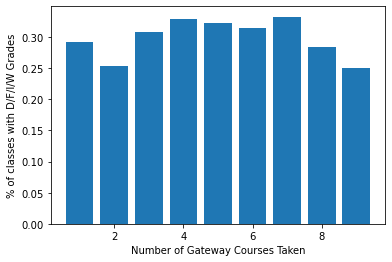

In [12]:
plt.bar(height=gates_dfiw,x=gates_dfiw.index)
plt.xlabel('Number of Gateway Courses Taken')
plt.ylabel('% of classes with D/F/I/W Grades')

Text(0.5, 1.0, 'GPA by Percent of classes with DFIW grades')

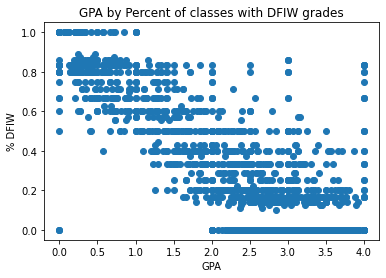

In [6]:
plt.scatter(x=df.GPA,y=df.DFIW)
plt.xlabel('GPA')
plt.ylabel('% DFIW')
plt.title('GPA by Percent of classes with DFIW grades')

In [16]:
df

,GPA,FS_RET,FF_RET,GatewayCount,CourseCount,DFIW,DFIW_Gateway
0,4.00,1,1,5,5,0.000000,0.00
1,3.58,1,1,5,9,0.000000,0.00
2,0.00,0,0,1,1,1.000000,1.00
3,4.00,0,0,0,1,0.000000,0.00
4,0.92,1,1,1,5,0.750000,1.00
...,...,...,...,...,...,...,...
2574,1.23,1,0,5,6,0.333333,0.40
2575,3.41,1,1,3,7,0.000000,0.00
2576,0.00,1,0,4,5,0.600000,0.75
2577,2.84,1,1,2,8,0.142857,0.00


In [15]:
df.fillna(0,inplace=True)

In [41]:
# make testing and training data for model
data_model_x = df.drop(columns=['FS_RET','FF_RET'])

data_model_y=df['FS_RET'].astype('category')

# make test and training data
X_train, X_test, Y_train, Y_test= train_test_split(data_model_x,data_model_y,test_size=0.4,random_state=11)

data_model = data_model_x.assign(target=data_model_y)

In [42]:
Y_test

923     1
2429    0
1472    0
1642    1
2295    1
       ..
1480    1
886     1
2126    0
1362    0
2323    1
Name: FS_RET, Length: 1032, dtype: category
Categories (2, int64): [0, 1]

In [7]:
corr_chk = data_model.corrwith(data_model['target'])
corr_chk.sort_values(ascending=False,inplace=True)
corr_chk.head(10)

GPA             0.516357
CourseCount     0.051708
GatewayCount    0.030567
GatewayLoad    -0.037530
DFIW_Gateway   -0.500227
DFIW           -0.558555
dtype: float64

In [8]:
import seaborn as sn
import matplotlib.pyplot as plt

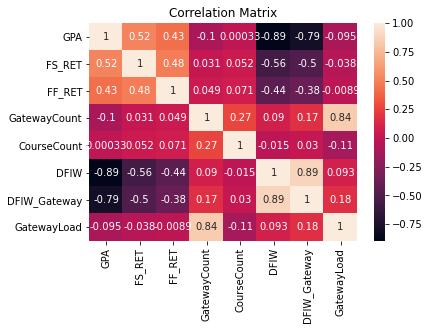

In [9]:
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.title("Correlation Matrix")
plt.show()

In [10]:
from sklearn import linear_model
import statsmodels.api as sm

In [43]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 0.9799757164778468
Coefficients: 
 [ 0.02729088  0.07274705 -0.02004606 -0.57291154  0.00240995 -0.39750501]


In [44]:
# with statsmodels
X_train = sm.add_constant(X_train) # adding a constant
 
model = sm.OLS(Y_train, X_train).fit()
predictions = model.predict(X_train) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                 FS_RET   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     131.0
Date:                Thu, 21 Oct 2021   Prob (F-statistic):          4.50e-134
Time:                        03:53:55   Log-Likelihood:                -515.51
No. Observations:                1547   AIC:                             1045.
Df Residuals:                    1540   BIC:                             1082.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.9800      0.063     15.604   

In [30]:
predictions

0       0.960009
1       1.048885
2       0.062284
3       1.034404
4       0.451094
          ...   
2574    0.729596
2575    0.981449
2576    0.497618
2577    0.870691
2578    0.892315
Length: 2579, dtype: float64

Text(0.5, 1.0, 'Residuals Histogram')

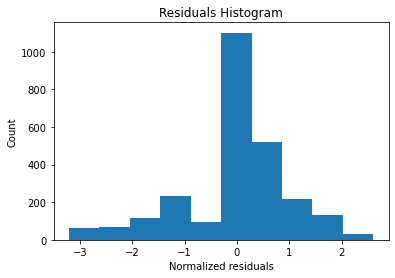

In [21]:
plt.hist(model.resid_pearson)
plt.ylabel('Count')
plt.xlabel('Normalized residuals')
plt.title('Residuals Histogram')

## Decision Tree Model

In [33]:
DT_model = DecisionTreeClassifier().fit(X_train,Y_train)
DT_predict = DT_model.predict(X_test)
print(DT_predict)

[1 1 0 ... 0 1 1]


In [34]:
classes = ['Lost','retained']
labels = Y_test.values.to_numpy()

error = abs(DT_predict - labels)

In [35]:
print('Average absolute error:', round(np.mean(error), 2), 'degrees.')

Average absolute error: 0.21 degrees.


In [36]:
f1 = sklearn.metrics.f1_score(Y_test, DT_predict, average = 'weighted',labels=np.unique(DT_predict))
prec = sklearn.metrics.precision_score(Y_test, DT_predict, average = 'weighted')
acc = sklearn.metrics.accuracy_score(Y_test, DT_predict)
recall = sklearn.metrics.recall_score(Y_test, DT_predict, average = 'weighted')

print('accuracy: {0}\nprecision: {1}\nrecall: {2}\nf1: {3}'.format(acc,prec,recall,f1))

accuracy: 0.7926356589147286
precision: 0.8021002343609157
recall: 0.7926356589147286
f1: 0.7967425668932837


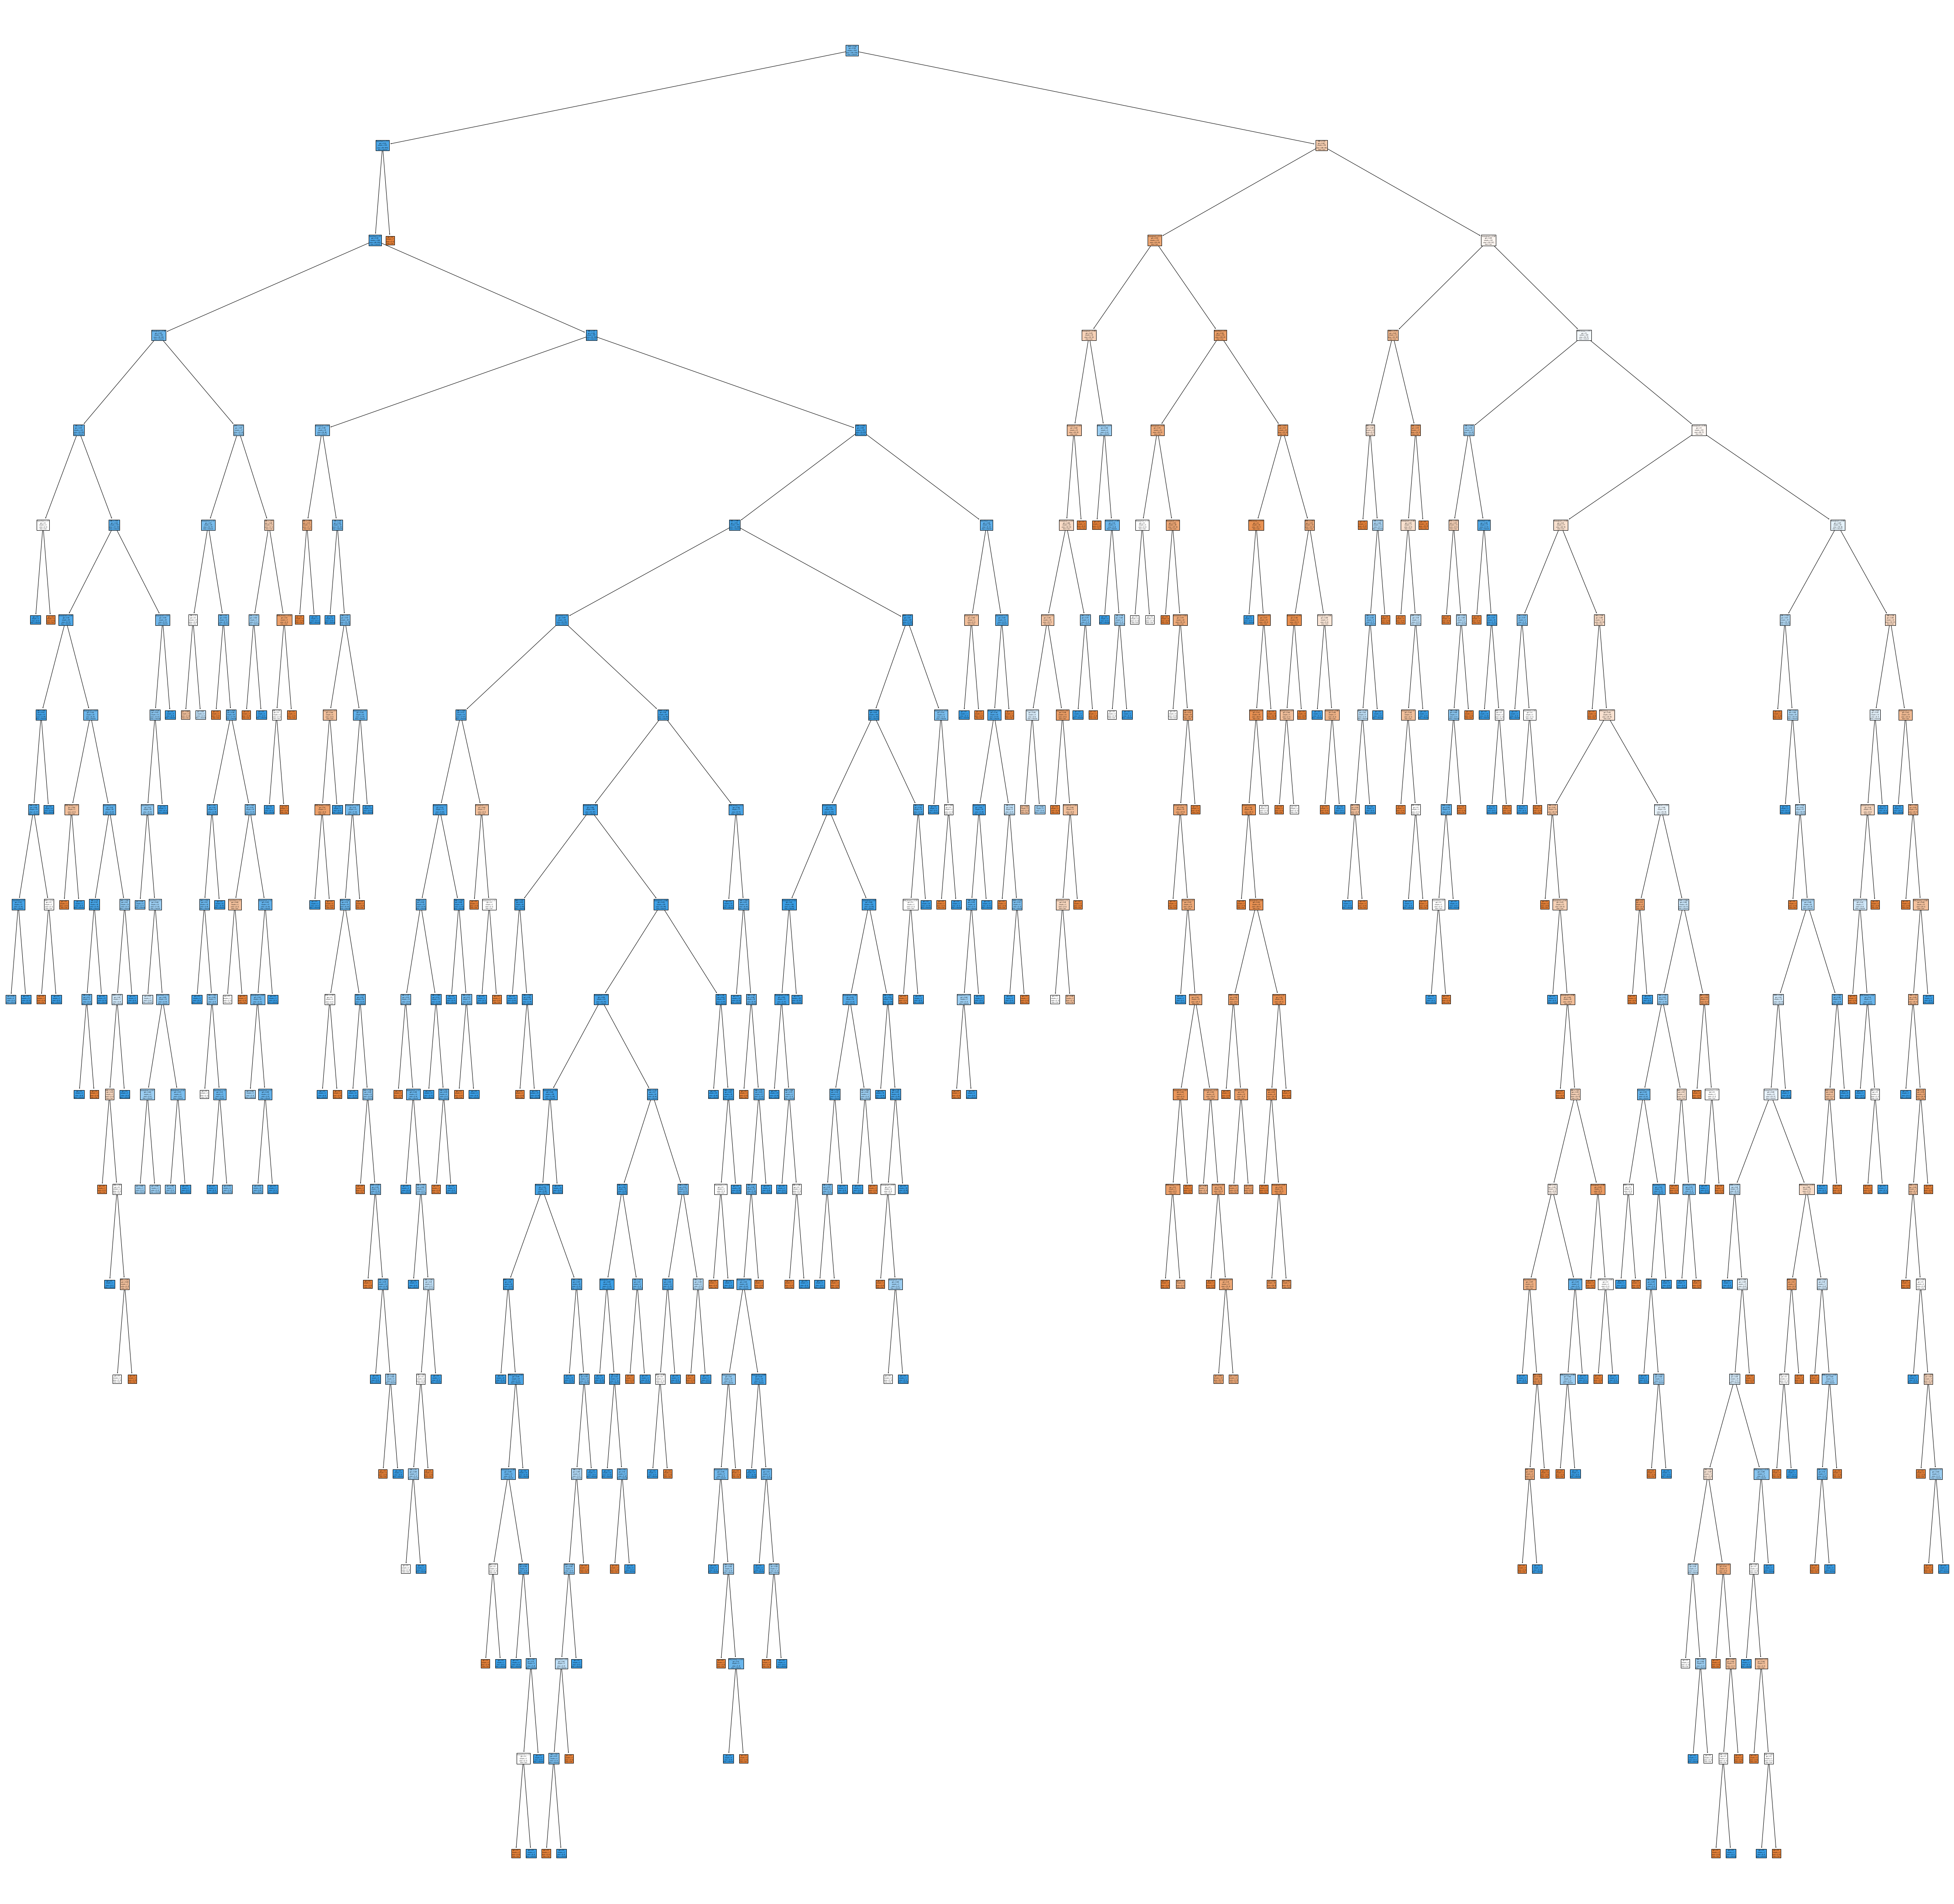

In [62]:
fig = plt.figure(figsize=(80,80))
_ = tree.plot_tree(DT_model, 
                   feature_names=data_model_x.columns,  
                   class_names=classes,
                   filled=True)
fig.savefig('imagename.png')

Text(0.5, 1.0, 'Regression Plot')

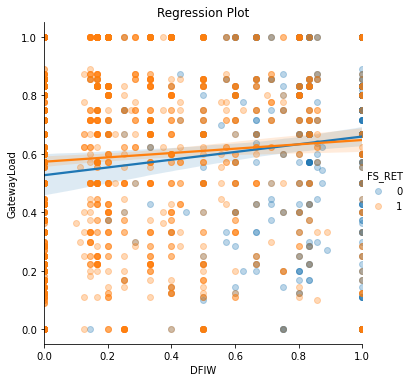

In [53]:
sns.lmplot(x = 'DFIW', y = 'GatewayLoad', data = df, hue = 'FS_RET',scatter_kws={'alpha':0.3})
plt.title('Regression Plot')